In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
tf.enable_eager_execution() #Включаем режим динамического графа

In [3]:
#В режиме статического графа
#В таком режиме сначала строится полный граф нейронной сети, затем он замораживается и изменять его больше нельзя.

#В режиме динамического графа (жадного выполнения)
#Такой режим используется во многих фреймворках. 
#В этом случае граф описывается с помощью произвольного python кода, и потом #есть возможность менять этот код в ходе работы. 

In [4]:
#ПАРАМЕТРЫ ДЛЯ СЕТИ

NUM_EPOCHS = 10 # колличество эпох в сети
BATCH_SIZE = 64 # Батч - колличество образцов показываемых на одной итерации градиентного спуска.
LEARNING_RATE = 0.0001 #скорость обучения

In [5]:
(train_x,train_y),(test_x,test_y) = tf.keras.datasets.mnist.load_data() #загружаем dataset mnist

In [6]:
print(train_x.shape,train_x.dtype)
print(train_y.shape,train_y.dtype)
print(test_x.shape,test_x.dtype)
print(test_y.shape,test_y.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


In [7]:
train_x = train_x.reshape(-1,28,28,1).astype(np.float32)/255. #меняем размерность, меняем тип и приводим
test_x = test_x.reshape(-1,28,28,1).astype(np.float32)/255.

train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

In [8]:
print(train_x.shape,train_x.dtype)
print(train_y.shape,train_y.dtype)
print(test_x.shape,test_x.dtype)
print(test_y.shape,test_y.dtype)

(60000, 28, 28, 1) float32
(60000,) int32
(10000, 28, 28, 1) float32
(10000,) int32


In [9]:
some_samples = train_x[:10, ...] #32 элемента для отображения 

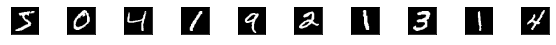

In [10]:
#Отображаем данные с помощью matpotlib
fig = plt.figure(figsize=(10,6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(10,10,j+1)
    ax.imshow(some_samples[j,:,:,0],cmap = 'gray')
    plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
#tf.data — пакет внутри tensorflow, который предоставляет различные удобные функции для работы с данными. 
#Dataset. from_tensor_slices — класс с функцией, которая сделает нам датасет с тензорами
#С помощью цепной последовательности функции можно модифицировать 
#Обучение будет происходить в несколько эпох. Одна эпоха = один показ датасета.

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))

In [13]:
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])#перемешиваем данные в датас

In [14]:
train_ds = train_ds.repeat(NUM_EPOCHS)#устанавливаем колличество эпох 

In [15]:
train_ds = train_ds.batch(BATCH_SIZE)#устанавливем батч

In [16]:
from tensorflow import layers
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model,self).__init__()
    
        self.Conv1 =  tf.layers.Conv2D(32,(5,5),activation = tf.nn.relu,padding = 'same')
        self.Conv2 = tf.layers.Conv2D(64,(5,5),activation = tf.nn.relu,padding = 'same')
        self.Fc1 = tf.layers.Dense(256,activation = tf.nn.relu)
        self.Fc2 = tf.layers.Dense(10,activation = None)
        self.MaxPooling =tf.layers.MaxPooling2D((2,2),(2,2),padding = 'same')
    def __call__(self,inp):
        out = self.Conv1(inp)
        out = self.MaxPooling(out)
        out = self.Conv2(out)
        out = self.MaxPooling(out)
        out = tf.layers.flatten(out)
        out = self.Fc1(out)
        out = self.Fc2(out)
        return out

In [17]:
model = Model()


In [18]:
#Вычисляем ошибку
def loss(logits,labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels))

In [19]:
#Вычисляем точность
def accuracy(logits, labels):
    prdictions = tf.argmax(logits,axis=1,output_type = tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(prdictions,labels),dtype=tf.float32))

In [20]:
#optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)#создаем опимизатор на базе градиентного спуска
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)#создаем опимизатор на базе ADAM

In [21]:
writer =tf.contrib.summary.create_file_writer("logs/adam_maxim") #запишем логи работы в файл

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [22]:
global_step = tf.train.get_or_create_global_step() #номер глобального шага

In [23]:
%%time

for (images,labels) in train_ds:
    
    #forward шаг 1 - прямое распространение
    #создание градиентной ленты
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits,labels)
    
    #backward 2 шаг - обратное распространение ошибки
    grads = tape.gradient(loss_value,model.variables)
    optimizer.apply_gradients(zip(grads,model.variables),global_step=global_step)
    
    #шаг 3
    
    if global_step.numpy() % 200 == 0:
        test_logits=model(test_x[:256,...])
        accuracy_value=accuracy(test_logits,test_y[:256,...])
        
        print("[%4d] Accuary: %5.2f %%" % (global_step.numpy(),accuracy_value.numpy()*100))
        with writer.as_default():
            with tf.contrib.summary.always_record_summaries():
                tf.contrib.summary.scalar('accuracy',accuracy_value)
                tf.contrib.summary.scalar('loss',loss_value)
        
        

Instructions for updating:
Use keras.layers.flatten instead.
[ 200] Accuary: 92.19 %
[ 400] Accuary: 96.88 %
[ 600] Accuary: 98.05 %
[ 800] Accuary: 98.83 %
[1000] Accuary: 99.22 %
[1200] Accuary: 99.61 %
[1400] Accuary: 99.22 %
[1600] Accuary: 99.61 %
[1800] Accuary: 99.61 %
[2000] Accuary: 98.83 %
[2200] Accuary: 100.00 %
[2400] Accuary: 100.00 %
[2600] Accuary: 98.83 %
[2800] Accuary: 100.00 %
[3000] Accuary: 99.61 %
[3200] Accuary: 99.61 %
[3400] Accuary: 99.61 %
[3600] Accuary: 99.22 %
[3800] Accuary: 99.61 %
[4000] Accuary: 100.00 %
[4200] Accuary: 100.00 %
[4400] Accuary: 99.22 %
[4600] Accuary: 99.22 %
[4800] Accuary: 99.22 %
[5000] Accuary: 100.00 %
[5200] Accuary: 100.00 %
[5400] Accuary: 99.61 %
[5600] Accuary: 99.61 %
[5800] Accuary: 100.00 %
[6000] Accuary: 99.61 %
[6200] Accuary: 99.22 %
[6400] Accuary: 100.00 %
[6600] Accuary: 100.00 %
[6800] Accuary: 100.00 %
[7000] Accuary: 99.61 %
[7200] Accuary: 99.22 %
[7400] Accuary: 99.22 %
[7600] Accuary: 99.61 %
[7800] Accuary: 

In [25]:
test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()

print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 99.13 %


In [28]:
def test_digit(sample):
    
    sample = sample[np.newaxis, ...]
    logits = model(sample)
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1,2,1)
    ax.imshow(sample[0,:,:,0],cmap = 'gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction[0], align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted number: {}'.format(ans))
    

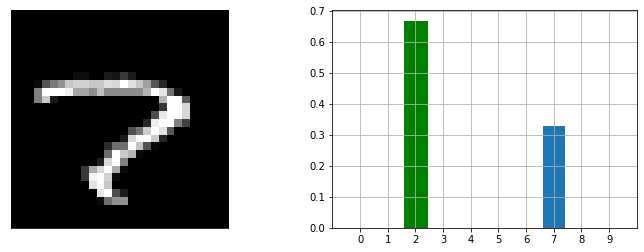

Predicted number: 2
True Answer: 7


In [38]:
import random
idx = random.randint(0,test_x.shape[0])
sample = test_x[idx,...]
test_digit(sample)
print('True Answer: {}'.format(test_y[idx]))